In [1]:
import os
import json
import numpy as np
import mne
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
# import shap

from scipy.stats import zscore
from scipy.signal import welch
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader


In [2]:
# Global configuration
DATASET_PATH = "dataset"
SFREQ = 250
WINDOW_SIZE = 100
STEP_SIZE = 50

CHANNELS = ['Fp1','Fp2','F3','F4','T7','T8','P3','P4']
N_CHANNELS = len(CHANNELS)


In [3]:
def get_label_from_filename(filename):
    subject_id = int(filename.split("Abby")[0])
    return 1 if subject_id <= 28 else 0  # 1=ASD, 0=Control


In [4]:
def load_eeg(file_path):
    raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
    raw.pick_types(eeg=True)
    raw.filter(1., 40.)

    data = raw.get_data()
    ch_names = raw.ch_names

    fixed = np.zeros((N_CHANNELS, data.shape[1]))

    for i, ch in enumerate(CHANNELS):
        if ch in ch_names:
            fixed[i] = data[ch_names.index(ch)]

    fixed = np.where(
        fixed.std(axis=1, keepdims=True) == 0,
        fixed,
        zscore(fixed, axis=1)
    )

    return fixed


In [5]:
def create_windows(data, label, subject_id):
    X, y, groups = [], [], []

    for start in range(0, data.shape[1] - WINDOW_SIZE, STEP_SIZE):
        window = data[:, start:start + WINDOW_SIZE]
        X.append(window.T)
        y.append(label)
        groups.append(subject_id)

    return X, y, groups


In [6]:
def build_dataset(dataset_path):
    X_all, y_all, groups_all = [], [], []
    subject_counter = 0

    for file in sorted(os.listdir(dataset_path)):
        if file.endswith(".set"):
            data = load_eeg(os.path.join(dataset_path, file))
            label = get_label_from_filename(file)

            X, y, g = create_windows(data, label, subject_counter)
            X_all.extend(X)
            y_all.extend(y)
            groups_all.extend(g)

            subject_counter += 1

    return (
        np.array(X_all, dtype=np.float32),
        np.array(y_all),
        np.array(groups_all)
    )


In [7]:
X, y, groups = build_dataset(DATASET_PATH)
print("Samples:", X.shape)
print("Labels:", np.unique(y, return_counts=True))


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment


C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)


C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)


- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------


C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00


C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 6 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_30580\1062022458.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Samples: (91538, 100, 8)
Labels: (array([0, 1]), array([45836, 45702], dtype=int64))


In [8]:
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


In [9]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [10]:
class ChannelAttention(nn.Module):
    def __init__(self, channels, ratio=8):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels//ratio)
        self.fc2 = nn.Linear(channels//ratio, channels)

    def forward(self, x):
        avg = x.mean(dim=1)
        attn = torch.sigmoid(self.fc2(F.relu(self.fc1(avg))))
        return x * attn.unsqueeze(1)


In [11]:
class EEG_ASD_Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(8, 32, 15, padding=7)
        self.bn1 = nn.BatchNorm1d(32)

        self.ms3 = nn.Conv1d(32,32,3,padding=1)
        self.ms5 = nn.Conv1d(32,32,5,padding=2)
        self.ms7 = nn.Conv1d(32,32,7,padding=3)
        self.bn2 = nn.BatchNorm1d(32)

        self.attn = ChannelAttention(32)
        self.dw = nn.Conv1d(32,32,3,padding=1,groups=32)
        self.bn3 = nn.BatchNorm1d(32)

        self.pool = nn.AvgPool1d(4)
        self.lstm1 = nn.LSTM(32,64,batch_first=True,bidirectional=True)
        self.lstm2 = nn.LSTM(128,32,batch_first=True,bidirectional=True)

        self.fc1 = nn.Linear(64,64)
        self.fc2 = nn.Linear(64,2)

    def forward(self, x):
        x = x.permute(0,2,1)
        x = F.elu(self.bn1(self.conv1(x)))
        x = self.bn2(self.ms3(x)+self.ms5(x)+self.ms7(x))
        x = self.attn(x.permute(0,2,1)).permute(0,2,1)
        x = F.elu(self.bn3(self.dw(x)))
        x = self.pool(x)
        x,_ = self.lstm1(x.permute(0,2,1))
        x,_ = self.lstm2(x)
        x = F.elu(self.fc1(x[:,-1]))
        return self.fc2(x)


In [30]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0, path="artifacts/best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_acc, model):
        if self.best_score is None:
            self.best_score = val_acc
            torch.save(model.state_dict(), self.path)
        elif val_acc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            torch.save(model.state_dict(), self.path)
            self.counter = 0


In [31]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, epochs=50, device="cpu"):
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # -------- METRIC STORAGE --------
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=8)

    for epoch in range(epochs):
        # ================== TRAIN ==================
        model.train()
        running_loss = 0.0
        train_preds, train_trues = [], []

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_preds.extend(out.argmax(1).cpu().numpy())
            train_trues.extend(yb.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(train_trues, train_preds)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # ================== VALIDATION ==================
        model.eval()
        val_running_loss = 0.0
        val_preds, val_trues = [], []

        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)

                out = model(Xb)
                loss = criterion(out, yb)

                val_running_loss += loss.item()
                val_preds.extend(out.argmax(1).cpu().numpy())
                val_trues.extend(yb.cpu().numpy())

        val_loss = val_running_loss / len(val_loader)
        val_acc = accuracy_score(val_trues, val_preds)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # ================== LOG ==================
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Acc: {train_acc:.3f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_acc:.3f}"
        )

        # ================== EARLY STOPPING ==================
        early_stopping(val_acc, model)
        if early_stopping.early_stop:
            print("🛑 Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    train_loader,
    val_loader,
    epochs=50,
)



Epoch 1/50 | Train Loss: 0.0256 | Train Acc: 0.991 | Val Loss: 1.1490 | Val Acc: 0.775
Epoch 2/50 | Train Loss: 0.0235 | Train Acc: 0.991 | Val Loss: 1.0814 | Val Acc: 0.779
Epoch 3/50 | Train Loss: 0.0217 | Train Acc: 0.992 | Val Loss: 1.1000 | Val Acc: 0.783
Epoch 4/50 | Train Loss: 0.0191 | Train Acc: 0.993 | Val Loss: 1.2398 | Val Acc: 0.775
Epoch 5/50 | Train Loss: 0.0195 | Train Acc: 0.993 | Val Loss: 1.2973 | Val Acc: 0.774
Epoch 6/50 | Train Loss: 0.0153 | Train Acc: 0.995 | Val Loss: 1.3276 | Val Acc: 0.794
Epoch 7/50 | Train Loss: 0.0173 | Train Acc: 0.994 | Val Loss: 1.2517 | Val Acc: 0.777
Epoch 8/50 | Train Loss: 0.0140 | Train Acc: 0.995 | Val Loss: 1.2096 | Val Acc: 0.779
Epoch 9/50 | Train Loss: 0.0152 | Train Acc: 0.994 | Val Loss: 1.2455 | Val Acc: 0.773
Epoch 10/50 | Train Loss: 0.0126 | Train Acc: 0.995 | Val Loss: 1.5504 | Val Acc: 0.784
Epoch 11/50 | Train Loss: 0.0134 | Train Acc: 0.995 | Val Loss: 1.2297 | Val Acc: 0.792
Epoch 12/50 | Train Loss: 0.0119 | Train 

NameError: name 'plot_training_curves' is not defined

##   vdsjb

In [12]:
train_loader = DataLoader(EEGDataset(X_train,y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(EEGDataset(X_test,y_test), batch_size=64)

model = EEG_ASD_Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_loss, val_acc = [], []

for epoch in range(30):
    model.train()
    total = 0
    for xb,yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total += loss.item()

    train_loss.append(total/len(train_loader))

    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb,yb in val_loader:
            preds.extend(model(xb).argmax(1).numpy())
            trues.extend(yb.numpy())

    acc = accuracy_score(trues,preds)
    val_acc.append(acc)
    print(f"Epoch {epoch+1} | Loss {train_loss[-1]:.4f} | Val Acc {acc:.3f}")


Epoch 1 | Loss 0.4724 | Val Acc 0.715
Epoch 2 | Loss 0.2856 | Val Acc 0.752
Epoch 3 | Loss 0.2225 | Val Acc 0.737
Epoch 4 | Loss 0.1784 | Val Acc 0.712
Epoch 5 | Loss 0.1408 | Val Acc 0.762
Epoch 6 | Loss 0.1106 | Val Acc 0.777
Epoch 7 | Loss 0.0872 | Val Acc 0.770
Epoch 8 | Loss 0.0728 | Val Acc 0.776
Epoch 9 | Loss 0.0598 | Val Acc 0.800
Epoch 10 | Loss 0.0544 | Val Acc 0.791
Epoch 11 | Loss 0.0461 | Val Acc 0.789
Epoch 12 | Loss 0.0423 | Val Acc 0.807
Epoch 13 | Loss 0.0381 | Val Acc 0.769
Epoch 14 | Loss 0.0356 | Val Acc 0.782
Epoch 15 | Loss 0.0278 | Val Acc 0.770
Epoch 16 | Loss 0.0284 | Val Acc 0.777


KeyboardInterrupt: 

## Evalution

In [34]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # -------- LOSS --------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)

    # -------- ACCURACY --------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


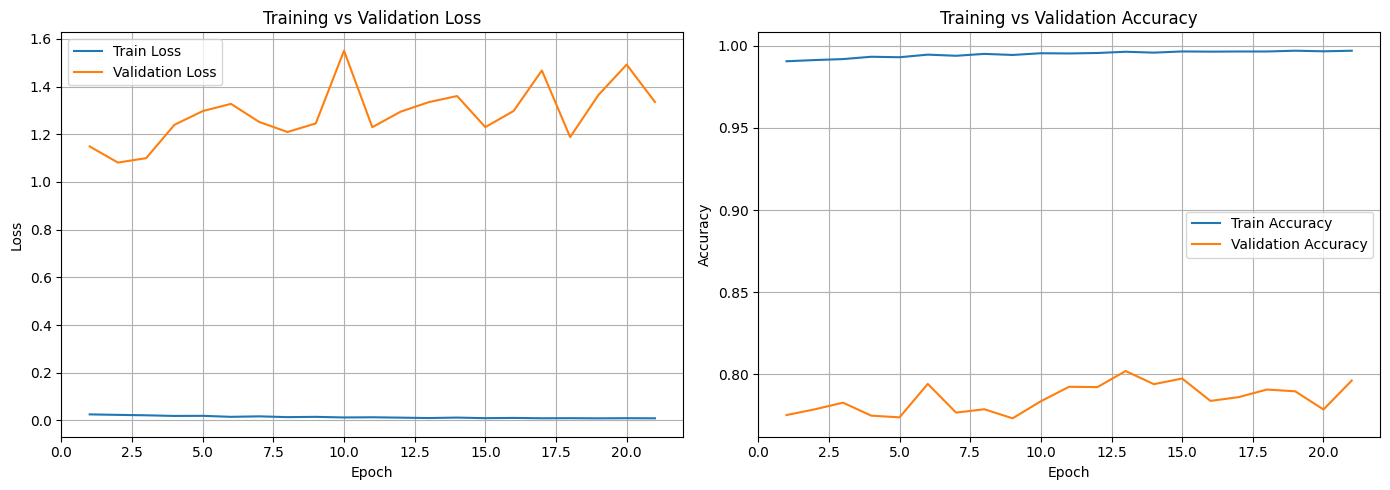

Confusion Matrix:
 [[ 5098  3087]
 [  776 10549]]

Classification Report:
               precision    recall  f1-score   support

     Control       0.87      0.62      0.73      8185
         ASD       0.77      0.93      0.85     11325

    accuracy                           0.80     19510
   macro avg       0.82      0.78      0.79     19510
weighted avg       0.81      0.80      0.79     19510



In [39]:

plot_training_curves(train_losses, val_losses, train_accs, val_accs)

## Confusion Matrix and Classification Report
model.load_state_dict(torch.load("artifacts/best_model.pth"))
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        all_preds.extend(model(xb).argmax(1).numpy())
        all_trues.extend(yb.numpy())
cm = confusion_matrix(all_trues, all_preds)
cr = classification_report(all_trues, all_preds, target_names=["Control", "ASD"])
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", cr)
#!/usr/bin/env python3



              precision    recall  f1-score   support

           0       0.81      0.62      0.70      8185
           1       0.76      0.89      0.82     11325

    accuracy                           0.78     19510
   macro avg       0.78      0.75      0.76     19510
weighted avg       0.78      0.78      0.77     19510



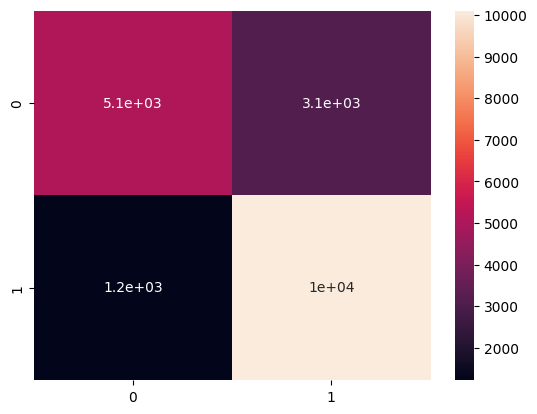

In [36]:
print(classification_report(trues,preds))
sns.heatmap(confusion_matrix(trues,preds),annot=True)
plt.show()


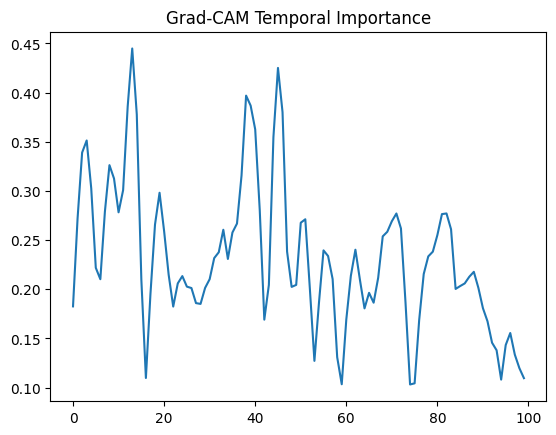

In [40]:
sample = torch.tensor(X_test[0:1], requires_grad=True)
pred = model(sample)
pred[:,pred.argmax()].backward()
cam = sample.grad.abs().mean(dim=2).numpy()
plt.plot(cam[0])
plt.title("Grad-CAM Temporal Importance")
plt.show()


In [41]:
os.makedirs("artifacts",exist_ok=True)
torch.save(model.state_dict(),"artifacts/model.pth")

with open("artifacts/config.json","w") as f:
    json.dump({
        "channels":CHANNELS,
        "window":WINDOW_SIZE,
        "sfreq":SFREQ
    },f,indent=4)


In [42]:
import json, os

os.makedirs("artifacts", exist_ok=True)

# Channels
with open("artifacts/channels.json", "w") as f:
    json.dump(CHANNELS, f, indent=4)

# Window config
with open("artifacts/window_config.json", "w") as f:
    json.dump({
        "window_size": WINDOW_SIZE,
        "step_size": STEP_SIZE,
        "sampling_rate": SFREQ
    }, f, indent=4)

# Label map
with open("artifacts/label_map.json", "w") as f:
    json.dump({
        "0": "Control",
        "1": "ASD"
    }, f, indent=4)
